In [1]:
%load_ext autoreload
%autoreload 2

# Temporal downscaling (Tweening)

<p align ="center">
  <img src="../assets/images/tweening.png" width="85%" height="85%" >
</p>

This notebook gives an example of hourly land surface temperature predictions using the IBM granite-geospatial-land-surface-temperature model. This is a first foray into using AI to attain temperature information at a high spatial resolution and high temporal frequency for regions of interest, at scale. The intention of this notebook is to demonstrate a unique feature made possible with this fine-tuned model, namely temporal downscaling. In essence, this comes down to generating land surface temperature maps between satellite observations (8-16 days), depicted by the blue bars and blue boardered blocks in the image above, at the hourly cadence. 

In order to do this, we need to prepare data for the model to inference on. In the absence of real-time remote-sensing data, we assume that for any point in time the most recent acquisition of Landsat provides an accurate representation of the morphology for the region of interest in terms of buildings, vegetation, waterbodies, etc. To generate this dataset, we make use of Landsat 8 bands (B2, B3, B4, B5, B6, B7) and replicate these for each hour over 3-days, as depicted by black boarded blocks between the acquisitions in the image above, stacked with correspondig hourly ERA5 T2m, as depicted by the red dashed line in the image above. 

The steps in this approach are:

1. Produce an HLS temporal dataset using the most recent HLS L30 observation. 
2. Stack the HLS L30 data from step 1. with hourly ERA5-Land T2m.

Refer to: [tweening_data_preparation](./3_tweening_data_preparation.ipynb), for steps to produce the tweening dataset described above.

3. Execute inferencing on the Stacked hourly inputs from step 2.
4. Compute the geospatial mean:
     1. per hourly prediction
     2. per hourly ERA5-Land T2m
     3. per hourly ERA5-Land Skin Termperature
     4. plot these variables as a time-series to visualize the temporal variability of the predictions against ERA5-Land data.
5. Produce and visualise an animation of the predicted LST

This approach lends itself to temporal downscaling, with potential to leverage further remote sensing datasets or model estimates of LST to improve predictions.

In [2]:
import pandas as pd
import matplotlib.pyplot as plt 
from matplotlib import cm
import glob
import os
import sys
import rasterio
import xarray as xr
import rioxarray as rx
import numpy as np
import shutil
import yaml
import pandas as pd
import pylab as plb
from pathlib import Path
sys.path.append("../")

from collections import Counter
from matplotlib.colors import Normalize 
from scipy.interpolate import interpn
import matplotlib as mpl
from huggingface_hub import hf_hub_download
mpl.rcParams['agg.path.chunksize'] = 10000
import subprocess
import datetime
from datetime import datetime as dt
import rasterio as rs
from matplotlib.animation import FuncAnimation
import matplotlib
from utils.plotting import stack_rgb, load_lst, plot_rgb_and_lst, analyze_rasters
from IPython.display import Image, display
if 'google.colab' in sys.modules:
  import gdown


#matplotlib.use('Agg')  
#import dask
import logging
logging.getLogger("lightning").setLevel(logging.ERROR)

# Model and data preparation

Let's start with downloading the model checkpoints and configs from HuggingFace:

In [ ]:
# Download the model checkpoints, specify the path in local_dir
ckpt_path = hf_hub_download(repo_id="ibm-granite/granite-geospatial-land-surface-temperature", 
                            filename="LST_model.ckpt", 
                            local_dir="../")

# Download the config, specify path save directory in local_dir
config_path_full_tile = hf_hub_download(repo_id="ibm-granite/granite-geospatial-land-surface-temperature", 
                        filename="config_full_tile.yaml", 
                        local_dir="../")

In [ ]:
# Specify path to where all data will be downloaded to
data_path = Path("../data")
data_path.mkdir(parents=True, exist_ok=True)

# Download and uncompress full-tile dataset from Zenodo 
dataset_path = Path("../data/granite-geospatial-land-surface-temperature-tweening-dataset.tar.gz")
if 'google.colab' in sys.modules:
  try:
    gdown.download("https://drive.google.com/uc?id=1wUsdu_I4_IErX86H536AyEUQA_AAyaN3", str(dataset_path))
  except:
    print(f"Download failed via g.down. Reverting to Zenodo.")
    !wget "https://zenodo.org/records/14034636/files/granite-geospatial-land-surface-temperature-tweening-dataset.tar.gz?download=1" -O {str(dataset_path)}
else:
  !wget "https://zenodo.org/records/14034636/files/granite-geospatial-land-surface-temperature-tweening-dataset.tar.gz?download=1" -O {str(dataset_path)}

city = "Johannesburg"
season = "winter"
date_start = "2023-07-12"
date_end = "2023-07-14"

!tar -xf {str(dataset_path)} --directory {str(data_path)}
inputs_path = data_path.joinpath(f"dccstor/sarl_data/v2-5-data/granite-geospatial-land-surface-temperature-tweening-dataset/inputs", city, season)

# Rename downloaded files prefix to match grep in config
input_files = glob.glob("../data/dccstor/sarl_data/v2-5-data/granite-geospatial-land-surface-temperature-tweening-dataset/inputs/*/*/*.stacked_inputs.tif")
for file in input_files:
    os.rename(file, file.replace(".stacked_inputs.tif", ".inputs.tif"))

targets_path = data_path.joinpath(f"dccstor/sarl_data/v2-5-data/granite-geospatial-land-surface-temperature-tweening-dataset/targets", city, season)
predictions_path = data_path.joinpath("predictions-full-tiles-tweening/")
predictions_path.mkdir(parents=True, exist_ok=True)


## Execute infencing on stacked hourly inputs

At this point, we use the granite-geospatial-land-surface-temperature model to inference on data from a single city generated through the process explained at the start of this notebook.  


Note:  Running inference might take a couple of minutes if you are using CPU only.

In [ ]:
# Run inference
conf = yaml.safe_load(Path(config_path_full_tile).read_text())
data_bands = "[" + ",".join([str(x) for x in conf['data']['init_args']['output_bands']]) + "]"

_ = subprocess.call(['terratorch', 'predict', '-c', config_path_full_tile,
                     '--ckpt_path', str(ckpt_path), 
                     '--predict_output_dir', str(predictions_path), 
                     '--data.init_args.predict_data_root', str(inputs_path), 
                     '--data.init_args.predict_dataset_bands', data_bands,
                     '--data.check_stackability', str(False)])

# If the above block of code using subprocess.call does not work, use the string stored in run_str to do the inferencing via the CLI.
#run_str = f"terratorch predict -c {config_path_full_tile} --ckpt_path {str(ckpt_path)} --predict_output_dir {str(predictions_path)} --data.init_args.predict_data_root {str(inputs_path)} --data.init_args.predict_dataset_bands {data_bands} --data.check_stackability False"
#print(run_str)

## Calculate hourly means

### Predictions

In [7]:
def create_data(path):
    
    tif_fps = sorted(glob.glob(os.path.join(path, '*.tif')))
    dataset_name = []

    for tfs in tif_fps:
        print(f"Processing file: {tfs}")
        ds = xr.open_dataset(tfs)
        date = (os.path.basename(tfs).split(".")[2:4])
        date = ''.join(date)
        print(date)
        ds = ds.assign_coords(time=date)
        dataset_name.append(ds)
    dataset_name = xr.concat(dataset_name, dim='time')
    return dataset_name

In [ ]:
pred = create_data(predictions_path)
pred['time'] = pd.DatetimeIndex(pred['time'].values)

In [9]:
timestamps = pd.date_range(start=date_start, periods=len(pred.time), freq='h')  # Adjust the start date and frequency based on tweening inputs lenght
#timestamps

In [10]:
pred_mean = pred.mean(dim=['x','y'])
pred_mean = pred_mean.squeeze('band')
pred_mean

<xarray.Dataset> Size: 880B
Dimensions:      (time: 72)
Coordinates:
    band         int64 8B 1
    spatial_ref  int64 8B 0
  * time         (time) datetime64[ns] 576B 2023-07-12 ... 2023-07-14T23:00:00
Data variables:
    band_data    (time) float32 288B 7.17 6.13 5.091 4.259 ... 10.73 9.763 8.93

### ERA5-Land T2m and Skin Temperature 

In [11]:
def read_raster_data(input_pattern, band_index, timestamps):
    raster_files = sorted(glob.glob(input_pattern))
    data_arrays = []
    
    for i, raster_path in enumerate(raster_files):
        try:
            with rasterio.open(raster_path) as src:
                raster = src.read(band_index)  # Read the specified band
                data_array = xr.DataArray(
                    data=raster,
                    dims=["y", "x"],
                    coords={"y": range(raster.shape[0]), "x": range(raster.shape[1])}
                )
                data_arrays.append(data_array.expand_dims(time=[timestamps[i]]))  # Add time dimension
        except Exception as e:
            print(f"Error reading {raster_path}: {e}")

    return xr.concat(data_arrays, dim='time')
 
t2m_merged = read_raster_data(os.path.join(inputs_path, '*inputs.tif'), band_index=7, timestamps=timestamps)
st_merged = read_raster_data(os.path.join(inputs_path, '*inputs.tif'), band_index=11, timestamps=timestamps)


Text(0, 0.5, 'ERA5 $T_{2m}$ Temperature ($^{0}C$)')

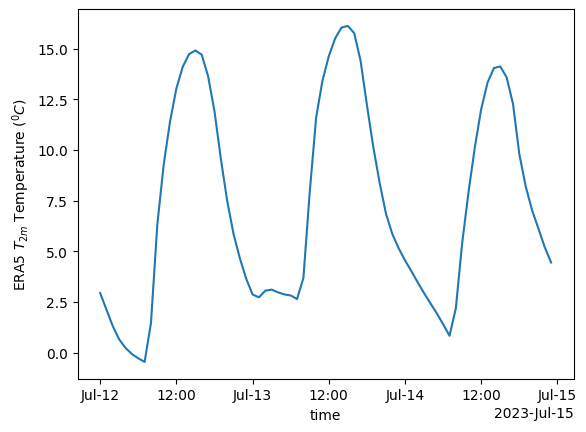

In [12]:
era5_land_t2m_subset = t2m_merged.sel(time=slice(date_start, date_end))
era5_land_t2m_subset_mean = era5_land_t2m_subset.mean(dim=['y', 'x'])
era5_land_t2m_subset_mean = era5_land_t2m_subset_mean 
era5_land_t2m_subset_mean.plot()
plt.ylabel(r'ERA5 $T_{2m}$ Temperature ($^{0}C$)', fontsize=10)


Text(0, 0.5, 'ERA5 Skin Temperature ($^{0}C$)')

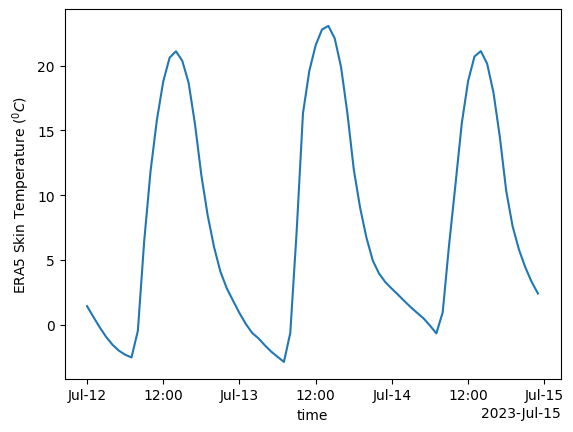

In [13]:
era5_land_st_subset = st_merged.sel(time=slice(date_start, date_end))
era5_land_st_subset_mean = era5_land_st_subset.mean(dim=['y', 'x'])
era5_land_st_subset_mean = era5_land_st_subset_mean 
era5_land_st_subset_mean.plot()
plt.ylabel(r'ERA5 Skin Temperature ($^{0}C$)', fontsize=10)

### LST Acquisition Mean and Std-Dev

In [14]:
lst_acq_path = targets_path.joinpath(f"johannesburg_zaf.T35JPM.20230712.T080131.lst.tif") # path to  calculated (not predicted by model) LST
lst_acq = xr.open_dataset(lst_acq_path)
date = (os.path.basename(lst_acq_path).split(".")[2:4])
date = ''.join(date)
local_shift = +2 #change based on the city's local time 
utm_time = date.split("T")[1]
local_time = int(utm_time) + (local_shift * 10000)
local_date = date.split("T")[0] + "T" + str(local_time)
print(local_date)
lst_acq = lst_acq.assign_coords(time=local_date)
lst_acq['time'] = pd.to_datetime(lst_acq['time'].values)
lst_acq

20230712T100131


<xarray.Dataset> Size: 12MB
Dimensions:      (band: 1, x: 1184, y: 1316)
Coordinates:
  * band         (band) int64 8B 1
  * x            (x) float64 9kB 6e+05 6e+05 6.001e+05 ... 6.355e+05 6.355e+05
  * y            (y) float64 11kB -2.87e+06 -2.87e+06 ... -2.91e+06 -2.91e+06
    spatial_ref  int64 8B ...
    time         datetime64[ns] 8B 2023-07-12T10:01:31
Data variables:
    band_data    (band, y, x) float64 12MB ...

In [15]:
lst_acq_mean = lst_acq.mean(dim=['x','y'])
lst_acq_mean

<xarray.Dataset> Size: 32B
Dimensions:      (band: 1)
Coordinates:
  * band         (band) int64 8B 1
    spatial_ref  int64 8B ...
    time         datetime64[ns] 8B 2023-07-12T10:01:31
Data variables:
    band_data    (band) float64 8B 12.65

In [16]:
lst_acq_std = lst_acq.std(dim=['x','y'])
lst_acq_std

<xarray.Dataset> Size: 32B
Dimensions:      (band: 1)
Coordinates:
  * band         (band) int64 8B 1
    spatial_ref  int64 8B ...
    time         datetime64[ns] 8B 2023-07-12T10:01:31
Data variables:
    band_data    (band) float64 8B 1.666

## Generate plot of the mean values to guage correlation between the predictions and the ERA5-Land hourly values

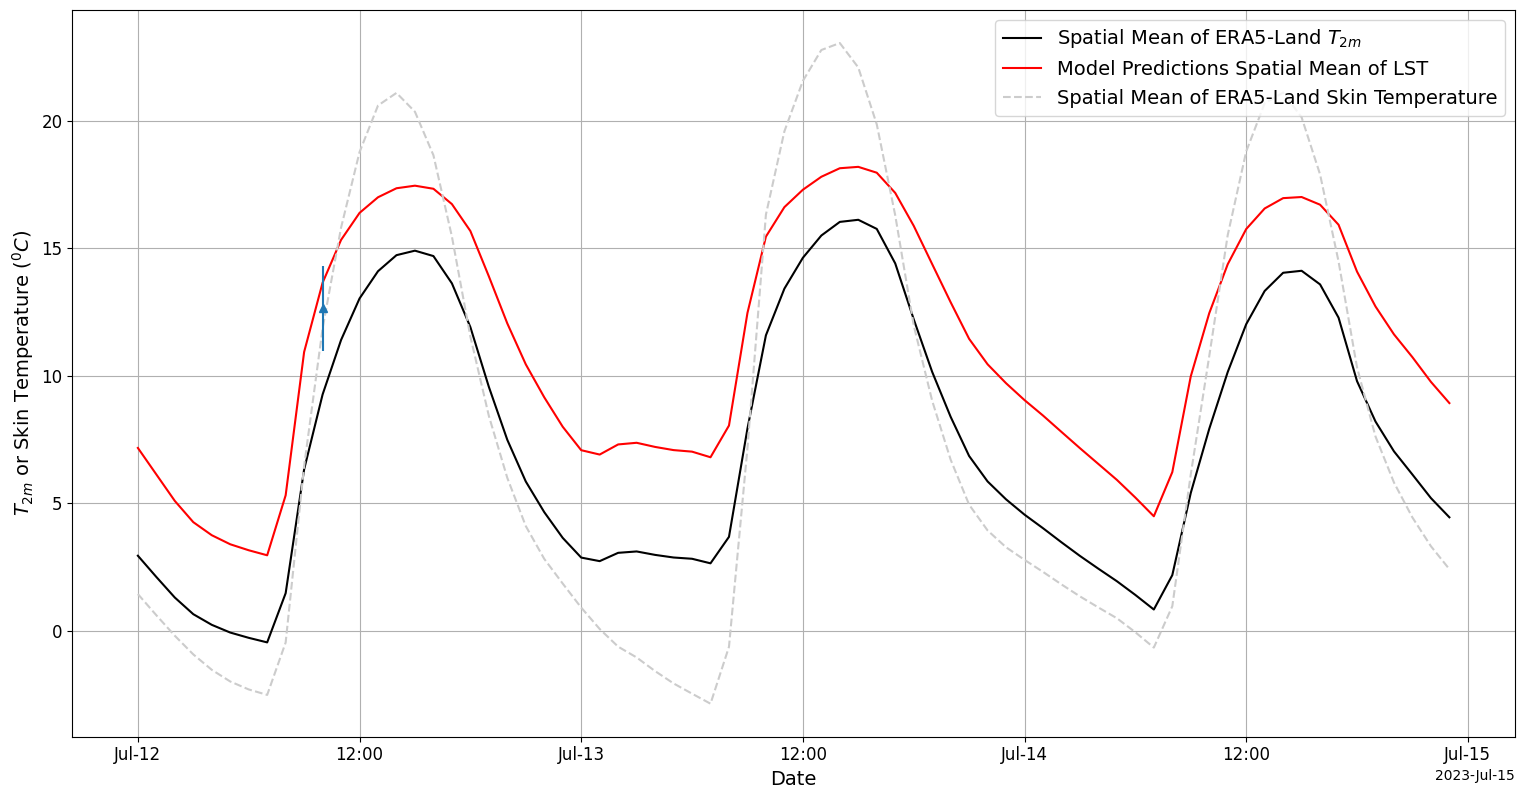

In [17]:
plt.figure(figsize=(15,8))
era5_land_t2m_subset_mean.plot(label=r'Spatial Mean of ERA5-Land $T_{2m}$', color ='k')
pred_mean['band_data'].plot(label=r'Model Predictions Spatial Mean of LST', color = 'r')
era5_land_st_subset_mean.plot(label=r'Spatial Mean of ERA5-Land Skin Temperature', color = '0.8', linestyle='--')
plt.errorbar(lst_acq['time'], lst_acq_mean['band_data'], lst_acq_std['band_data'], linestyle='None', marker='^')
plt.tight_layout()
plt.grid()
plt.legend(fontsize=14)
plt.xlabel('Date', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.ylabel(r'$T_{2m}$ or Skin Temperature ($^{0}C$)', fontsize=14)
plt.title(None)
plt.show()

## Generate and save animation of the predicted 3-day LST 

In [18]:
#Calculate the temporal min and max of the predictions for static colourbar
minmax = analyze_rasters(predictions_path)  

Raster data shape: (72, 1316, 1184)
5th Percentile (Global Minimum Value): 3.6848245
95th Percentile (Global Maximum Value): 18.468157


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-8.546461..16.19165].


Animation saved as Johannesburg_winter_lst_animation.gif


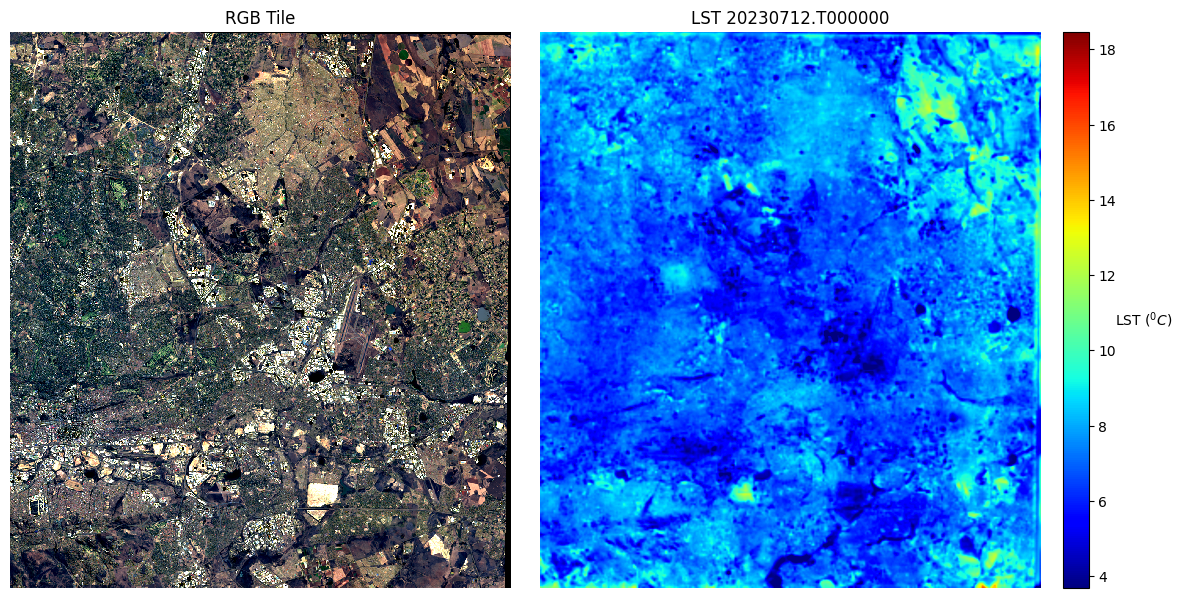

In [ ]:
# Load inputs files 
input_files = glob.glob(os.path.join(inputs_path, "*.tif"))
input_file = sorted(input_files)[1] if input_files else None

# Load predicted files 
pred_files = glob.glob(os.path.join(predictions_path, "*_pred.tif"))
pred_files = sorted(pred_files)  # Sort by date

# Define the output animation filename 
output_filename = '../Johannesburg_winter_lst_animation.gif'  # change animation 

# plot and save the animation
plot_rgb_and_lst(input_file, pred_files, minmax, output_file=output_filename)

# Display the saved animation
#display(Image(filename=output_filename))



In [ ]:
#Pre-computed animation of the city of Johannesburg summer tweening. Run this cell to visualise/play the animation.
display(Image(data=open('../assets/images/Johannesburg_summer_lst_animation.gif','rb').read(), format='gif'))

In [ ]:
#Pre-computed animation of the city of Johannesburg winter tweening. Run this cell to visualise/play the animation.
display(Image(data=open('../assets/images/Johannesburg_winter_lst_animation.gif','rb').read(), format='gif'))

That is how the Tweening works. You can now use the data we provided for Baltimore to implement Tweening on another city. You can also use [tweening_data_preparation](./3_tweening_data_preparation.ipynb) to prepare your own Tweening dataset for a city of your choice.